# 动漫风格图像退化 (HR -> LR) — 4× 下采样、轻量模糊/中值

本 Notebook 将高分辨率 (HR) 动漫图像退化为低分辨率 (LR)：**保持 4 倍下采样**，中值滤波与高斯模糊采用较轻参数（与 2× 版一致），以保留更多细节。输出保存到 **`dataset/lowres_4x/original`**，与 2× 版 `lowres_2x/original` 区分。


In [1]:
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn.functional as F
import math

# 设置路径
hr_dir = 'dataset/highres/original'
lr_dir = 'dataset/lowres_4x/original'

# 确保输出目录存在
os.makedirs(lr_dir, exist_ok=True)

# 获取所有 HR 图片路径
hr_image_paths = glob.glob(os.path.join(hr_dir, '*.[jp][pn]*g')) # 匹配 jpg, jpeg, png
hr_image_paths.sort()

print(f"总共找到 {len(hr_image_paths)} 张 HR 图片。")

总共找到 434 张 HR 图片。


## 展示 HR 示例图片

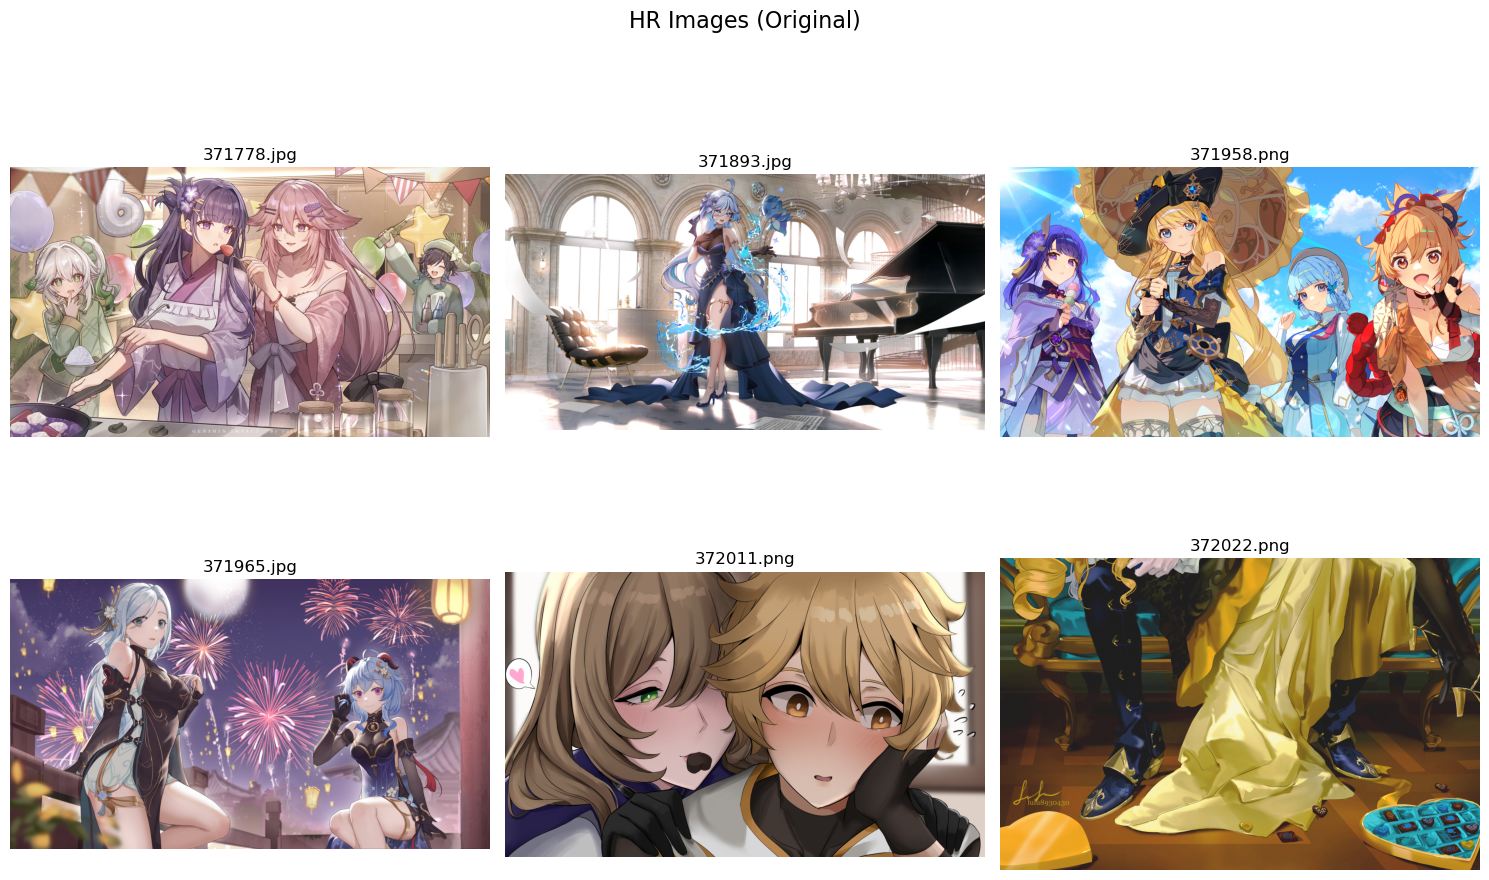

In [2]:
def show_images(image_paths, title="Images", num_images=6):
    num_images = min(num_images, len(image_paths))
    if num_images == 0:
        print("没有图片可展示。")
        return

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle(title, fontsize=16)
    axes = axes.flatten()

    for i in range(num_images):
        img = cv2.imread(image_paths[i])
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[i].imshow(img)
            axes[i].axis('off')
            axes[i].set_title(os.path.basename(image_paths[i]))
        else:
            axes[i].text(0.5, 0.5, 'Image Load Error', ha='center', va='center')
            axes[i].axis('off')

    # 隐藏多余的子图
    for j in range(num_images, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# 展示前 6 张 HR 图片
show_images(hr_image_paths, title="HR Images (Original)")

## 实现图像退化处理 (4倍下采样) - 优化版 (去除高频细节)

**优化流程 (使用 GPU 加速)：**
1. **预处理 (HR 阶段)**：使用中值滤波 (Median Filter) 抹除细小孤立的高频细节（如气泡、远处的灯笼、树叶）。
2. **缩放 (Downsample)**：使用 `cv2.INTER_CUBIC` 进行 4 倍下采样。
3. **二次中值滤波 (LR 阶段)**：再次使用中值滤波，进一步消除下采样后残留的细小斑点。
4. **低通滤波/保边平滑 (Blur)**：使用双边滤波 (Bilateral Filter) 平滑大面积纹理，保留主要线条。
5. **锐化 (Sharpening)**：使用 USM (Unsharp Mask) 增强线条。
6. **伪影/噪声 (Artifacts)**：通过保存为 JPEG 格式并设置较低的质量参数（如 `quality=85`）来添加轻微的压缩伪影。

*注：OpenCV 的 `cuda` 模块可以加速部分操作（如 Resize, Bilateral Filter, Gaussian Blur）。中值滤波在 OpenCV CUDA 中没有直接对应的函数，我们将使用 CPU 进行中值滤波，其他步骤尽量使用 GPU。*

In [3]:
# 辅助函数：PyTorch 实现的高斯模糊
def get_gaussian_kernel(kernel_size=5, sigma=1.5, channels=3):
    # 创建 1D 高斯核
    x_coord = torch.arange(kernel_size)
    x_grid = x_coord.repeat(kernel_size).view(kernel_size, kernel_size)
    y_grid = x_grid.t()
    xy_grid = torch.stack([x_grid, y_grid], dim=-1).float()

    mean = (kernel_size - 1)/2.
    variance = sigma**2.

    # 计算 2D 高斯核
    gaussian_kernel = (1./(2.*math.pi*variance)) * torch.exp(
        -torch.sum((xy_grid - mean)**2., dim=-1) / (2*variance)
    )
    gaussian_kernel = gaussian_kernel / torch.sum(gaussian_kernel)

    # 调整形状以适应 conv2d: (out_channels, in_channels/groups, kH, kW)
    gaussian_kernel = gaussian_kernel.view(1, 1, kernel_size, kernel_size)
    gaussian_kernel = gaussian_kernel.repeat(channels, 1, 1, 1)
    
    return gaussian_kernel

def gaussian_blur_pt(img_tensor, kernel_size=5, sigma=1.5):
    channels = img_tensor.shape[1]
    kernel = get_gaussian_kernel(kernel_size, sigma, channels).to(img_tensor.device)
    padding = kernel_size // 2
    return F.conv2d(img_tensor, kernel, padding=padding, groups=channels)

# 辅助函数：PyTorch 实现的中值滤波 (利用 unfold)
def median_blur_pt(img_tensor, kernel_size=5):
    # img_tensor: (B, C, H, W)
    B, C, H, W = img_tensor.shape
    padding = kernel_size // 2
    
    # 提取滑动窗口 (B, C*k*k, L)
    unfolded = F.unfold(img_tensor, kernel_size=kernel_size, padding=padding)
    
    # 重塑为 (B, C, k*k, H, W)
    unfolded = unfolded.view(B, C, kernel_size * kernel_size, H, W)
    
    # 在窗口维度上取中值
    median_tensor, _ = torch.median(unfolded, dim=2)
    return median_tensor

def degrade_image_hybrid(img_np, scale=4, device='cuda'):
    """
    混合处理：HR 阶段在 CPU 上处理以节省显存，LR 阶段在 GPU 上加速。
    img_np: numpy array (H, W, C), BGR 格式, 0-255
    """
    # 1. 预处理 (HR 阶段) - 中值滤波 (CPU)
    # 抹除细小孤立的高频细节。在 CPU 上做，避免 HR 图像撑爆显存
    img_median_hr = cv2.medianBlur(img_np, 3)
    
    # 2. 缩放 (Downsample) - 4倍下采样 (CPU)
    # 在 CPU 上下采样，进一步减小数据量
    h, w = img_median_hr.shape[:2]
    lr_h, lr_w = h // scale, w // scale
    img_lr_cpu = cv2.resize(img_median_hr, (lr_w, lr_h), interpolation=cv2.INTER_CUBIC)
    
    # 3. 准备 Tensor 并上传到 GPU
    # 转换为 RGB 并归一化到 0-1
    img_rgb = cv2.cvtColor(img_lr_cpu, cv2.COLOR_BGR2RGB)
    img_tensor = torch.from_numpy(img_rgb).float().permute(2, 0, 1).unsqueeze(0) / 255.0
    img_tensor = img_tensor.to(device)
    
    # 4. 二次中值滤波 (LR 阶段) (GPU)
    img_lr_gpu = median_blur_pt(img_tensor, kernel_size=3)
    
    # 5. 低通滤波 (Blur) (GPU)
    img_smooth = gaussian_blur_pt(img_lr_gpu, kernel_size=3, sigma=0.8)
    
    # 6. 锐化 (Sharpening) - USM (Unsharp Mask) (GPU)
    img_blur_for_usm = gaussian_blur_pt(img_smooth, kernel_size=3, sigma=1.0)
    amount = 0.8
    img_sharp = img_smooth + (img_smooth - img_blur_for_usm) * amount
    img_sharp = torch.clamp(img_sharp, 0.0, 1.0)
    
    # 7. 转回 Numpy (CPU)
    out_tensor = img_sharp.squeeze(0).permute(1, 2, 0).cpu().numpy()
    out_bgr = cv2.cvtColor((out_tensor * 255.0).astype(np.uint8), cv2.COLOR_RGB2BGR)
    
    return out_bgr

# 确定设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 处理所有图片
lr_image_paths = []
for hr_path in hr_image_paths:
    filename = os.path.basename(hr_path)
    lr_path = os.path.join(lr_dir, filename)
    
    # 读取 HR 图片
    img_hr = cv2.imread(hr_path)
    if img_hr is None:
        print(f"无法读取图片: {hr_path}")
        continue
        
    # 退化处理 (混合 CPU/GPU)
    with torch.no_grad(): # 确保不计算梯度，节省显存
        img_lr = degrade_image_hybrid(img_hr, scale=4, device=device)
    
    # 8. 伪影/噪声 (Artifacts) - 保存为 JPEG 并设置质量 (CPU)
    if filename.lower().endswith('.png'):
        filename = filename[:-4] + '.jpg'
        lr_path = os.path.join(lr_dir, filename)
        
    cv2.imwrite(lr_path, img_lr, [int(cv2.IMWRITE_JPEG_QUALITY), 85])
    lr_image_paths.append(lr_path)
    
    # 清理显存缓存
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

if lr_image_paths:
    print(f"成功处理并保存了 {len(lr_image_paths)} 张 LR 图片到 {lr_dir}。")

Using device: cuda
成功处理并保存了 434 张 LR 图片到 dataset/lowres_4x/original。


## 展示对应的 LR 示例图片

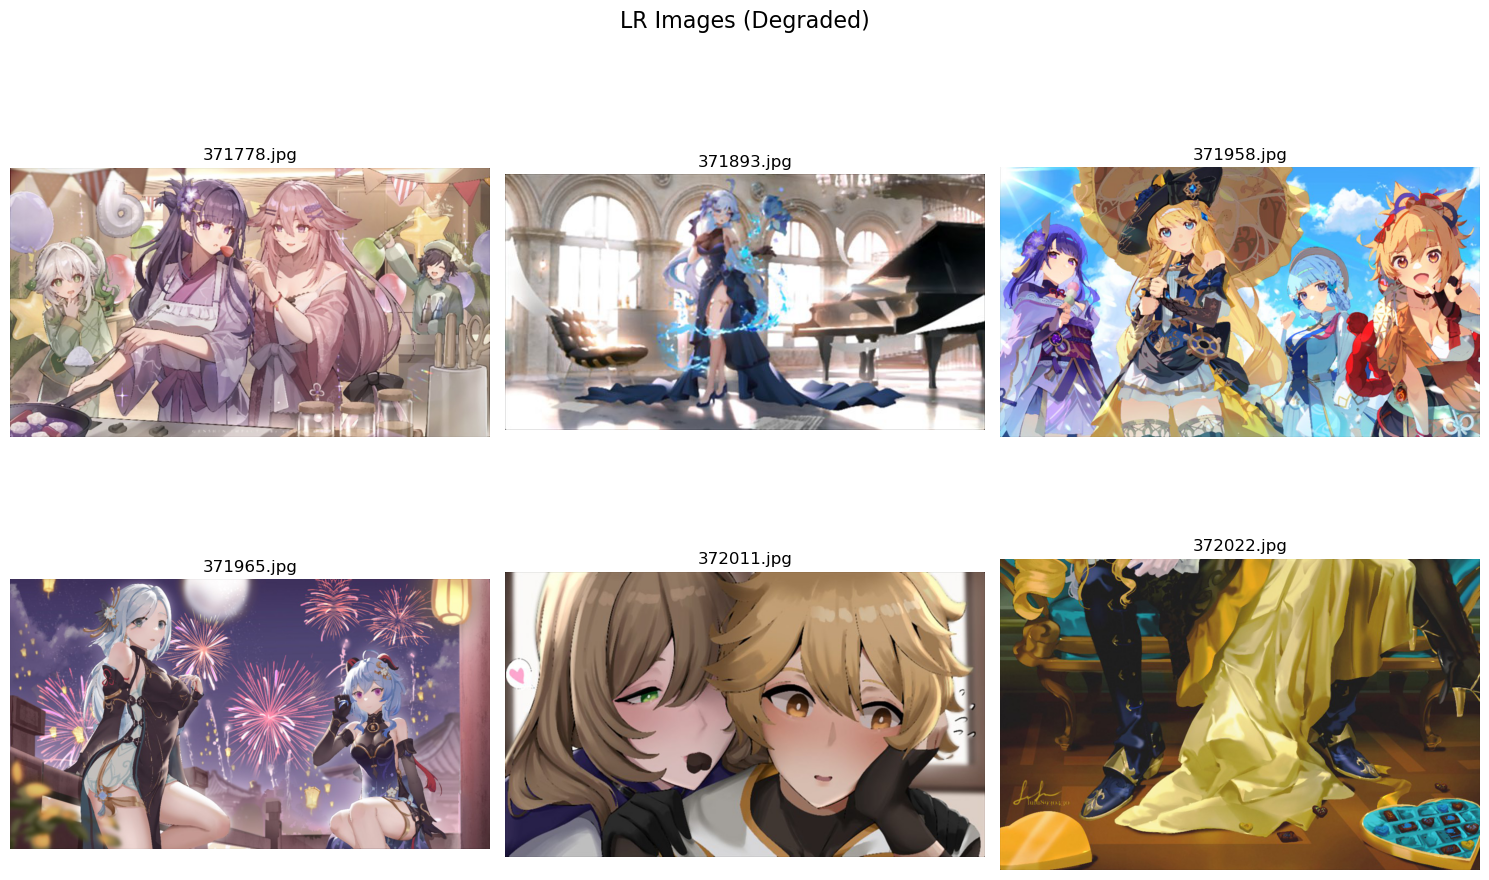

In [4]:
# 展示前 6 张 LR 图片
show_images(lr_image_paths, title="LR Images (Degraded)", num_images=6)